# Clique-Separator graph prototype

Attempting to create a sampler using Clique-separator graphs introduced by Ibarra (2009). 



In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import time
from parallelDG.graph import trajectory
import parallelDG.graph.graph as glib
import parallelDG.graph.decomposable as dlib
import parallelDG.graph.clique_separator_graph as clib
import parallelDG.graph.junction_tree as jtlib
import parallelDG.distributions.g_intra_class as gic
import parallelDG.auxiliary_functions as aux
from parallelDG.distributions import discrete_dec_log_linear as loglin
import parallelDG.mh_parallel as pdg
from networkx.drawing.nx_pydot import graphviz_layout

import parallelDG.mh_clique_separator as pcs
import parallelDG.mh_parallel as pdg
sns.set_style("whitegrid")
options = {
    "font_size": 8,
    "node_size": 100,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}


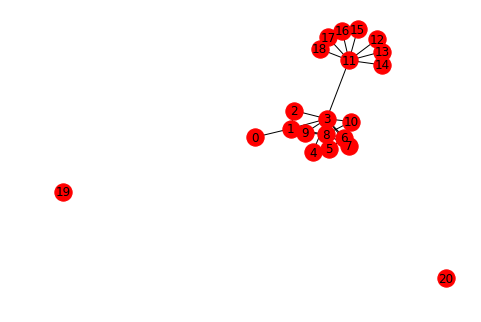

In [2]:
ibarra_graph = [(0,1), (1, 2), (2, 3), (1,3), 
               (3,4), (4, 5), (3, 5), 
               (5,6), (6, 8), (5, 8), 
               (6,7), (7, 8),
               (6,3), 
               (3,8), (3, 7), (3, 6), 
               (8,9), (3,9), 
               (1,9), (1,8), 
               (3,10), (8,10), 
               (3,11), 
               (11, 12), (12, 13), (11, 13), (11, 14), (13, 14), 
               (11, 15), (11, 16), (11, 17), (11, 18), (15, 16), (16, 17), (17, 18)]
G = nx.Graph(is_directed = False)
G.add_edges_from(ibarra_graph)
G.add_node((19))
G.add_node((20))
nx.draw(G, with_labels=True)

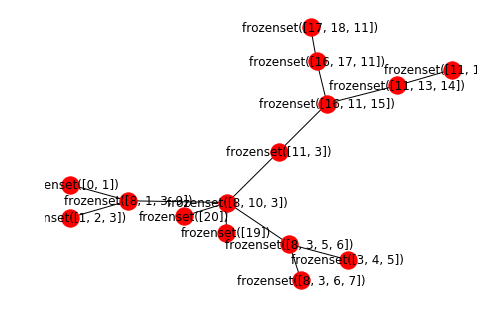

In [3]:
jt = dlib.junction_tree(G)
node =frozenset([11])
nx.draw(jt, with_labels=True)

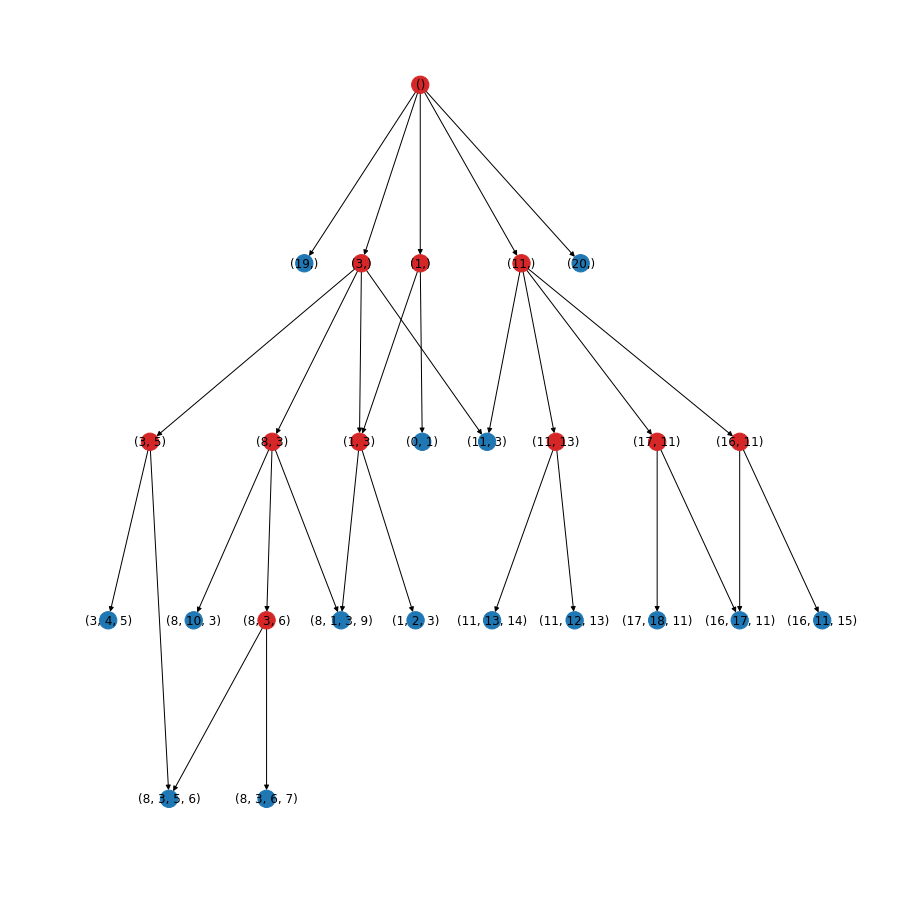

In [4]:
plt.figure(figsize = (12,12))
cs = clib.clique_separator_graph(jt)
cs.plot()

In [51]:
node = frozenset([3])

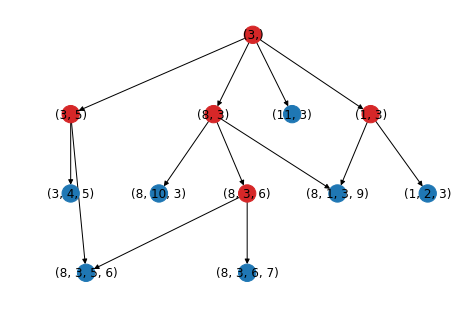

In [52]:
induced_graph = clib.subgraph_induced_by_subset(cs, node)
induced_graph.plot()

In [5]:
print(node)
clib.neighboring_nodes(cs, node)

frozenset([11])


{0: [],
 1: [[frozenset({3}), frozenset({1, 3}), frozenset({1, 2, 3})],
  [frozenset({3}), frozenset({1, 3}), frozenset({1, 3, 8, 9})],
  [frozenset({3}), frozenset({3, 8}), frozenset({3, 8, 10})]],
 2: [],
 3: [[frozenset({3}), frozenset({3, 5}), frozenset({3, 5, 6, 8})],
  [frozenset({3}), frozenset({3, 5}), frozenset({3, 4, 5})],
  [frozenset({3}),
   frozenset({3, 8}),
   frozenset({3, 6, 8}),
   frozenset({3, 6, 7, 8})]],
 4: [],
 5: [],
 6: [[frozenset(), frozenset({20})]],
 7: [[frozenset(), frozenset({19})]]}

In [7]:
clib.connect_partition(cs, frozenset([3]))

([(frozenset({11, 16, 17}), frozenset({11, 17})),
  (frozenset({11, 13, 14}), frozenset({11, 13})),
  (frozenset({0, 1}), frozenset({1})),
  (frozenset({20}), frozenset()),
  (frozenset({19}), frozenset())],
 0.0)

In [8]:
p = G.order()
sigma2 = 1.0
rho = 0.9
n = 100
delta = 5

Number of edges 34, number of nodes 21
loglikelihood 548.644835


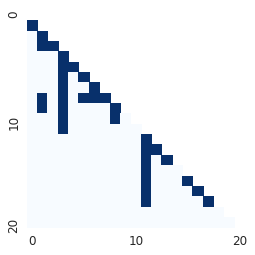

In [9]:
np.random.seed(2) # generates same data as in the paper
aux.plot_heatmap(nx.to_numpy_array(G), xticklabels=10, yticklabels=10)
ar_cov_mat = gic.cov_matrix(G, rho, sigma2)
ar_df = pd.DataFrame(np.random.multivariate_normal(np.zeros(p), ar_cov_mat, n))
print('Number of edges {}, number of nodes {}'.format(G.size(), G.order()))
print('loglikelihood {:2f}'.format(pdg.ggm_loglikelihood(dataframe=ar_df,
                                                         graph=G,
                                                         graph_prior=['uniform'], 
                                                         delta=delta)))

## Parallel Clique-separator graph

In [18]:
n_samples = 50000
randomize  = 100
graph_prior = ['uniform', 2.0, 4.0]
delta = 5.0
burnin = 200000
seed = 5

In [19]:
tic = time.time()
traj = pcs.sample_trajectory_ggm(dataframe=ar_df, 
                                 n_samples=n_samples,
                                 randomize=randomize, 
                                 graph_prior = graph_prior,
                                 delta = delta, 
                                 seed = seed)
toc = time.time()
print('Time taken {:.2f}sec'.format(toc-tic))

Parallel Metropolis-Hastings samples: 100%|██████████| 49999/49999 [01:39<00:00, 503.64it/s]

Total of 65046 updates, for an average of 1.30 per iteration or 655.15updates/sec
Acceptance rate 0.1150
Time taken 99.40sec


Text(0.5,0,'Sample number')

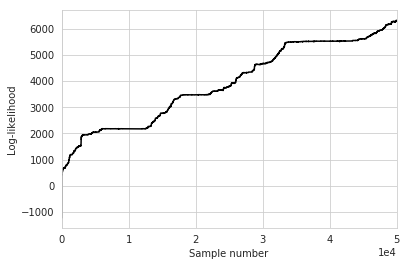

In [20]:
traj.log_likelihood().plot(color='black')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel('Log-likelihood')
plt.xlabel('Sample number')
#plt.ylim((800, 1600))a

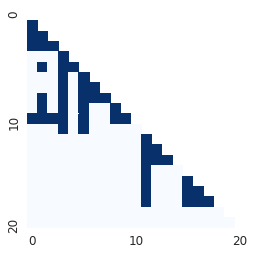

In [21]:
aux.plot_heatmap(nx.to_numpy_array(traj.maximum_likelihood_graph()), xticklabels=10, yticklabels=10)


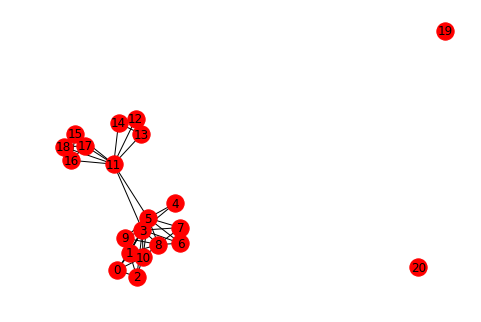

In [22]:
nx.draw(traj.maximum_likelihood_graph(), with_labels=True)

mcmc_index


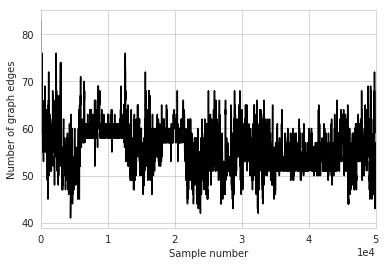

In [23]:
traj._size=None
traj.graph_updates = None
traj.set_graph_trajectories()
traj.size().plot(color = 'black')
size_mcmc_index = list(traj._size)
plt.xlabel('Sample number')
plt.ylabel('Number of graph edges')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))


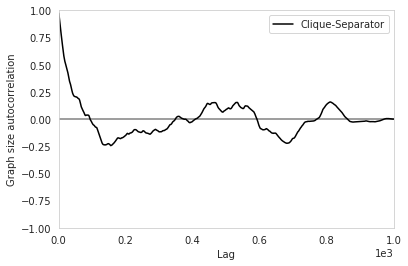

In [27]:
## Auto correlalation plot 
burnin = 1000
lag=1000
aux.autocorrelation_plot(size_mcmc_index[-burnin:], label = 'Clique-Separator', color = 'black', lag =lag)
plt.legend()
plt.ylabel('Graph size autocorrelation')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))


In [28]:
tic = time.time()
trajp = pdg.sample_trajectory_ggm(dataframe=ar_df, 
                                 n_samples=n_samples,
                                 randomize=randomize, 
                                 graph_prior = graph_prior,
                                 delta = delta, 
                                 seed = seed)
toc = time.time()
print('Time taken {:.2f}sec'.format(toc-tic))

Parallel Metropolis-Hastings samples: 100%|██████████| 49999/49999 [00:10<00:00, 4968.53it/s]

Total of 94030 updates, for an average of 1.88 per iteration or 9336.32updates/sec
Acceptance rate 0.4152
Time taken 10.08sec


(400, 600)

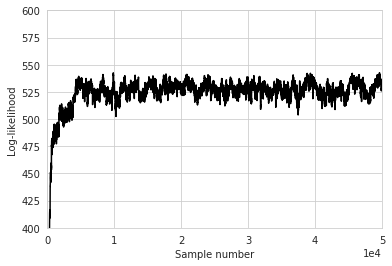

In [29]:
trajp.log_likelihood().plot(color='black')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel('Log-likelihood')
plt.xlabel('Sample number')
plt.ylim((400,600))

mcmc_index


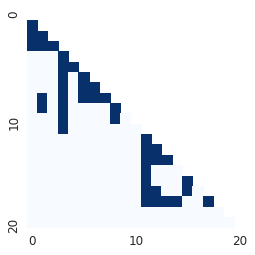

In [30]:
aux.plot_heatmap(nx.to_numpy_array(trajp.maximum_likelihood_graph()), xticklabels=10, yticklabels=10)


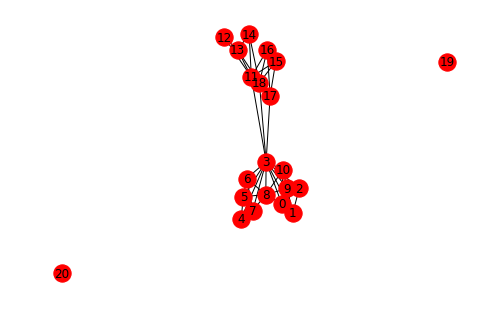

In [31]:
nx.draw(trajp.trajectory[-3], with_labels=True)

mcmc_index


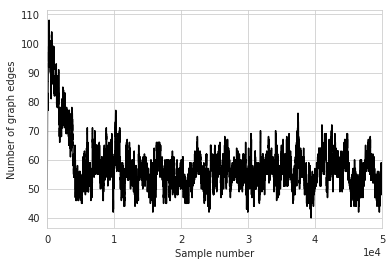

In [32]:
trajp._size=None
trajp.graph_updates = None
trajp.set_graph_trajectories()
trajp.size().plot(color = 'black')
size_mcmc_index = list(trajp._size)
plt.xlabel('Sample number')
plt.ylabel('Number of graph edges')
#plt.ylim((50, 250))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

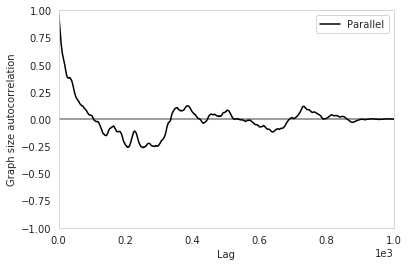

In [33]:
## Auto correlalation plot 
burnin = 1000
lag=1000
aux.autocorrelation_plot(size_mcmc_index[-burnin:], label = 'Parallel', color = 'black', lag =lag)
plt.legend()
plt.ylabel('Graph size autocorrelation')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))


In [70]:
## by mcmc index and subindex
## of the graph
traj.graph_updates = None
traj.set_graph_trajectories(index_type = 'mcmc_index')
acc_cs = aux.acceptance_ratio(traj.trajectory)

mcmc_index
Acceptance ratio 0.107402


In [72]:
## by mcmc index and subindex
## of the graph
trajp.graph_updates = None
trajp.set_graph_trajectories(index_type = 'mcmc_index')
acc_parallel = aux.acceptance_ratio(trajp.trajectory)
trajp.graph_updates = None
trajp.set_graph_trajectories(index_type = 'mcmc_subindex')
acc_parallel_subindex = aux.acceptance_ratio(trajp.trajectory)

mcmc_index
Acceptance ratio 0.235505
mcmc_subindex
Acceptance ratio 0.144402


In [ ]:
## Plotting joint acceptance ratio
x, y = smooth(x = None,y = acc_mcmc_subindex[1]  * 100)
xz, z = smooth(None,acc_mcmc_index[1] * 100 )
xu, u = smooth(None, acc_jt_mcmc_subindex[1] * 100)
xff, ff = smooth(None, f)

#x = list(range(len(acc_mcmc_subindex[1])))
#y = acc_mcmc_subindex[1]  * 100
#z = acc_mcmc_index[1] * 100
#u = acc_jt_mcmc_subindex[1] * 100
lw = 1
ax = plt.plot(xz, z, color='black', label='(a): Graph-updates - parallel',lw = lw)
plt.plot(x, y, color='black', label='(b): Graph-updates - serial', ls='--', lw = lw)
plt.plot(xu, u, color='grey', label='(c): Junction-updates - serial', ls = ':', lw=lw)
plt.plot(xff, ff, color='grey',label='(d): Graph-updates - single-move', ls = '-.', lw=lw)
plt.ylim((0, 20))
plt.xlim((0, max(x)))
plt.legend()
plt.xlabel('Sample number')
plt.ylabel('Cummulative acceptance rate (%)')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.annotate('(d)', xy=(650000,2))
plt.annotate('(b)', xy=(550000,3.6))
plt.annotate('(a)', xy=(80000,11))
plt.annotate('(c)', xy=(80000,15))
plt.grid(False)
save_location('ggm_acceptance_ratio_all')